In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from model import *
from pickle_cache import PickleCache
import pandas as pd
from  experiment_widgets import VariableMemoryExperiment
import json
from random import sample, randint
import string
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

pcache = PickleCache()

In [3]:
all_names = string.ascii_lowercase

def generate_trial(N):
    names = sample(all_names, k=N)
    return {'variables': [
        {'variable': names[i], 'value': randint(0, 9)}
        for i in range(N)
    ], 'presentation_time': N * 1500}

In [4]:
N_var = 2
N_trials = 10

def exp_name(N_var, N_trials):
    return f'varmem_{N_var}_{N_trials}'

experiment = {
    'trials': [generate_trial(N_var) for _ in range(N_trials)],
    'between_trials_time': 1000
}

exp = VariableMemoryExperiment(experiment=json.dumps(experiment), results='[]')

def on_result_change(_):
    pcache.set(exp_name(N_var, N_trials), {
        'experiment': experiment,
        'results': json.loads(exp.results)
    })
    
#exp.observe(on_result_change)

exp

VariableMemoryExperiment(experiment='{"trials": [{"variables": [{"variable": "b", "value": 8}, {"variable": "c…

In [5]:
def eval_response(N_var, experiment, results):
    df = []
    for i, (trial, result) in enumerate(zip(experiment['trials'], results)):
        correct = 0
        badvalue = 0
        badname = 0
        for j, var in enumerate(trial['variables']):
            category = None
            for var2 in result['response']:
                if var['variable'] == var2['variable']:
                    if var['value'] == int(var2['value']):
                        correct += 1
                    else:
                        badvalue += 1
                    break
            else:
                badname += 1

        df.append({
            'N_var': N_var,
            'correct': correct,
            'badvalue': badvalue,
            'badname': badname
        })

    return pd.DataFrame(df)  

def process_results(N_var, N_trials):
    data = pcache.get(exp_name(N_var, N_trials))
    experiment = data['experiment']
    results = data['results']
    return eval_response(N_var, experiment, results)

In [6]:
all_exp = [3, 4, 5, 6]
results = pd.concat([process_results(N_var, 10) for N_var in all_exp])

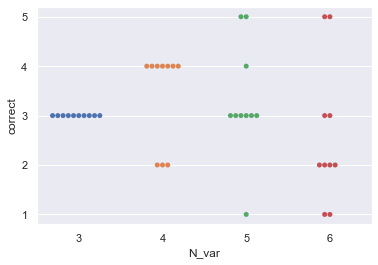

In [7]:
ax = sns.swarmplot(data=results, x='N_var', y='correct')
ax.set_yticks(list(range(1, 6)))

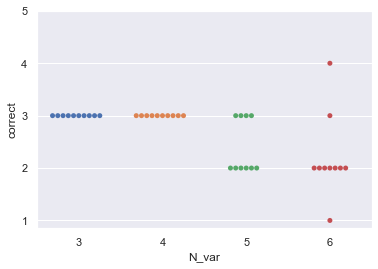

In [178]:
def model(variables):
    wm = WorkingMemory()
    
    for var in variables:
        wm.store_var_val(var['variable'], var['value'])

    response = []
    for var in variables:
        val = wm.fetch_var(var['variable'])
        if val is not None:
            response.append({'variable': var['variable'], 'value': val})
                        
    return response
        
def simulate_trials(N_var, N_trials):
    #data = pcache.get(exp_name(N_var, N_trials))
    #experiment = data['experiment']
    experiment = {
        'trials': [generate_trial(N_var) for _ in range(N_trials)]
    }
    
    response = [
        {'response': model(trial['variables'])} for trial in experiment['trials']
    ]

    return eval_response(N_var, experiment, response)

sim_results = pd.concat([simulate_trials(N_var, 10) for N_var in all_exp])
ax = sns.swarmplot(data=sim_results, x='N_var', y='correct')
ax.set_yticks(list(range(1, 6)))